In [ ]:
SEED = 42
PYTORCH_PRETRAINED_BERT_CACHE = "/Users/shagun/workspace/csc2511/tmp/"

In [ ]:
import os

# Local network environment settings - if needed
# Used to download pretrained BERT
# os.environ["http_proxy"] = "127.0.0.1:11233"
# os.environ["https_proxy"] = "127.0.0.1:11233"

In [ ]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")

In [117]:
import pytorch_pretrained_bert

In [118]:
import json
import gc

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

## Data Preparation

In [121]:
""" Load Data
    
    Outputs
    ----------
    df_data : pandas dataframe containing data

"""

df_data = pd.read_csv('EDU_pairs_TRAINING.csv')
df_data.head()

,File,Document,Sentence,EDU1,EDU2
0,wsj_0669,0,0,Nissan Motor Co. expects net income to reach 1...,U.S. $857 million
1,wsj_0669,0,0,U.S. $857 million,"in its current fiscal year, up from 114.6 bill..."
2,wsj_0669,0,0,"in its current fiscal year, up from 114.6 bill...","Yutaka Kume, president, said."
3,wsj_0669,0,1,Mr. Kume made the earnings projection for fisc...,"ending next March 31,"
4,wsj_0669,0,1,"ending next March 31,",in an interview with U.S. automotive writers


In [122]:
df_data.shape[0]

12083

In [123]:
df_data.EDU1.str.len().describe()

count    12083.000000
mean        42.825540
std         29.073975
min          2.000000
25%         21.000000
50%         36.000000
75%         58.000000
max        309.000000
Name: EDU1, dtype: float64

In [124]:
df_data.EDU2.str.len().describe()

count    12083.000000
mean        44.961930
std         29.097944
min          2.000000
25%         24.000000
50%         39.000000
75%         60.000000
max        309.000000
Name: EDU2, dtype: float64

#### Check how many edu's are really short

In [141]:
edu1_ix = df_data.index[df_data.EDU1.str.len() < 20]
edu2_ix = df_data.index[df_data.EDU2.str.len() < 20]

In [142]:
len(edu1_ix)

2688

In [143]:
len(edu2_ix)

2152

In [144]:
a = np.concatenate((edu1_ix, edu2_ix), axis=0)
len(a)

4840

In [145]:
len(np.unique(a))

4346

In [129]:
 df_data[df_data.EDU2.str.len() < 20].shape[0]

2152

In [148]:
# EDU1_check_count = df_data[df_data.EDU1.str.len() < k].shape[0]
checks = [5, 10, 20]

for k in checks:
    EDU1_check_count = df_data[df_data.EDU1.str.len() < k].shape[0]
    EDU1_check_fraction = EDU1_check_count/df_data.shape[0]
    EDU1_format = [k, EDU1_check_count, round(EDU1_check_fraction, 2)]

    EDU2_check_count = df_data[df_data.EDU2.str.len() < k].shape[0]
    EDU2_check_fraction = EDU2_check_count/df_data.shape[0]
    EDU2_format = [k, EDU2_check_count, round(EDU2_check_fraction, 2)]
    
    edu1_ix = df_data.index[df_data.EDU1.str.len() < k]
    edu2_ix = df_data.index[df_data.EDU2.str.len() < k]
    all_index = np.concatenate((edu1_ix, edu2_ix), axis=0)
    unique_rows = len(np.unique(all_index))
    unique_rows_fr = unique_rows/df_data.shape[0]
    rows_format = [k, unique_rows, round(unique_rows_fr, 2)]



    print ("EDU1 (length < {}): {} ({})".format(*EDU1_format))
    print ("EDU2 (length < {}): {} ({})".format(*EDU2_format))
    print ("Total Rows (length < {}): {} ({})".format(*rows_format))
    print("")

EDU1 (length < 5): 189 (0.02)
EDU2 (length < 5): 151 (0.01)
Total Rows (length < 5): 339 (0.03)

EDU1 (length < 10): 839 (0.07)
EDU2 (length < 10): 684 (0.06)
Total Rows (length < 10): 1468 (0.12)

EDU1 (length < 20): 2688 (0.22)
EDU2 (length < 20): 2152 (0.18)
Total Rows (length < 20): 4346 (0.36)



In [13]:
print(df_data.shape[0], df_data[df_data.EDU1.str.len() >= 20].shape[0], 
      df_data[df_data.EDU2.str.len() >= 20].shape[0],)

12083 9395 9931


#### Impose restrictions on length:

In [171]:
k = 20

In [172]:
df_full = df_data[df_data.EDU1.str.len() >= k].copy()
df_full.shape

(9395, 5)

In [173]:
df_full = df_full[df_full.EDU2.str.len() >= k].copy()
df_full.shape

(7737, 5)

In [40]:
# No Restrictions:

df_full = df_data.copy()
df_full.shape

(12083, 5)

In [25]:
# Create smaller sample for testing purposes

# df_full = df_full.sample(n=100)
# df_full.shape

(100, 5)

### Functions to create input representations

In [17]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [18]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [ ]:
def convert_sentence_pair(titles, descs, max_seq_length, tokenizer):
    features = []
    for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
        tokens_a = tokenizer.tokenize(title)
        print(tokens_a)
        tokens_b = None
        tokens_b = tokenizer.tokenize(desc)
        print(tokens_b)

        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)
#         print("TOKENS")
#         print(tokens)
        
#         print(segment_ids)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        print(input_ids)


        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1
        ))
    return features

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE)

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained(vocab_file, do_lower_case=True)

In [41]:
df_full.isnull().values.any()

False

In [ ]:
correct_pairs = convert_sentence_pair(df_full.EDU1.tolist(), df_full.EDU2.tolist(), max_seq_length=256, tokenizer=tokenizer)

In [43]:
len(correct_pairs)

12083

## Model

In [180]:
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

04/15/2019 02:35:38 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/shagun/workspace/csc2511/tmp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/15/2019 02:35:38 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /Users/shagun/workspace/csc2511/tmp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/v7/94d7pkyn0wb9s6yksjn6ctdc0000gn/T/tmpgnfu6oiv
04/15/2019 02:35:42 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hid

## Eval Correct Pairs

In [181]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []
logit_res = []
final_logit = []
final_res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
#         res.append(nn.functional.softmax(
#             model(input_ids, segment_ids, input_mask), dim=1
#         )[:, 0].detach().cpu().numpy())
        result = model(input_ids, segment_ids, input_mask)
        res.append(nn.functional.softmax(result, dim=1)[:, 0].detach().cpu().numpy())
        logit_res.append(result)     


print("FINAL")      
# print(res)        
final_res = np.concatenate(res)
final_logit = np.concatenate(logit_res)

04/15/2019 02:35:45 - INFO - bert -   ***** Running evaluation *****
04/15/2019 02:35:45 - INFO - bert -     Num examples = 7737
04/15/2019 02:35:45 - INFO - bert -     Batch size = 128


FINAL


In [182]:
print(len(final_res))
print(len(final_logit))

7737
7737


In [158]:
final_res

array([0.9999802 , 0.99995315, 0.99997365, ..., 0.9984876 , 0.99474853,
       0.05043331], dtype=float32)

In [159]:
np.save('NextEDU/nextedu_results_l10.npy', final_res)

In [160]:
final_logit

array([[ 5.6953754 , -5.135018  ],
       [ 5.40756   , -4.5601993 ],
       [ 5.552351  , -4.993738  ],
       ...,
       [ 3.9510546 , -2.5415049 ],
       [ 3.3196354 , -1.9243561 ],
       [-0.61386514,  2.3214889 ]], dtype=float32)

In [161]:
np.save('NextEDU/nextedu_logits_l10.npy', final_logit)

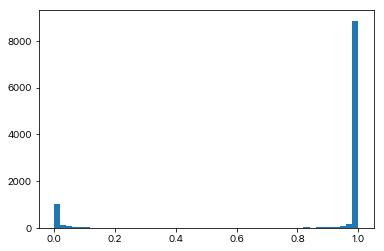

In [162]:
_ = plt.hist(final_res, bins=50)

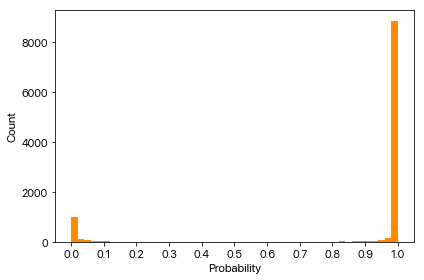

In [165]:
import matplotlib.pyplot as plt
import numpy as np
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# fig = plt.figure(figsize=[5, 5])
plt.hist(final_res, bins=50, color='darkorange')
plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(labelsize = 11)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Probability', fontsize=12)
plt.tight_layout()
plt.savefig('NextEDU/Probability_spread_orange_l10.jpg', dpi = 300)



In [184]:
from sklearn.metrics import accuracy_score
y_true = np.ones(7737)
print('TRUE',len(y_true))
y_pred = []
for i in final_res:
    if i > 0.5:
        y_pred.append(1)
    elif i < 0.5:
        y_pred.append(0)
print('PRED',len(y_pred))
print(accuracy_score(y_true, y_pred))
print(len(y_pred) - sum(y_pred))
print(sum(y_pred))

TRUE 7737
PRED 7737
0.902287708414114
756
6981


#### Calculate Accuracy

In [166]:
from sklearn.metrics import accuracy_score

In [167]:
y_true = np.ones(10615)

In [168]:
len(y_true)

10615

In [169]:
y_pred = []
for i in final_res:
    if i > 0.5:
        y_pred.append(1)
    elif i < 0.5:
        y_pred.append(0)

len(y_pred)

10615

In [170]:
accuracy_score(y_true, y_pred)

0.8728214790390956

In [179]:
len(y_pred) - sum(y_pred)

1350

In [178]:
len(y_pred)

10615

In [177]:
sum(y_pred)

9265

In [110]:
sum(final_res > 0.99) / len(final_res), sum(final_res > 0.9) / len(final_res), sum(final_res < 0.5) / len(final_res)

(0.7752213854175287, 0.8315815608706447, 0.15459736820326078)

In [111]:
np.where(final_res < 0.5)

(array([    9,    10,    13, ..., 12072, 12078, 12082]),)

In [113]:
idx = 10
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('During the next decade,', 'Mr. Kume said,')